In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# check the version of tensorflow
print(tf.__version__)

2.3.0


## Preprocessing Image Data & Generate Data Iterators


In [13]:
DIRECTORY_TRAIN = "drive/My Drive/Deep Learning Projects/Covid-19 and Pneumonia Classification/Covid19-dataset/train"
DIRECTORY_TEST = "drive/My Drive/Deep Learning Projects/Covid-19 and Pneumonia Classification/Covid19-dataset/test"

In [6]:
def preprocess_data(DIRECTORY_TRAIN, DIRECTORY_TEST):
    
    CLASS_MODE = "categorical"
    COLOR_MODE = "grayscale"
    TARGET_SIZE = (256, 256)
    BATCH_SIZE = 32
    
    # Set up an ImageDataGenerator and use data augmentation
    training_data_generator = ImageDataGenerator(
      rescale = 1.0/255,
      zoom_range = 0.1, 
      rotation_range = 25, 
      width_shift_range = 0.05, 
      height_shift_range = 0.05,
      validation_split = 0.2 
    )

    test_data_generator = ImageDataGenerator(rescale = 1.0/255)
    
    print('[INFO] Loading training data...')
    training_iterator = training_data_generator.flow_from_directory(
                DIRECTORY_TRAIN, class_mode = 'categorical', color_mode = 'grayscale', shuffle = True, 
                target_size = TARGET_SIZE, batch_size = BATCH_SIZE, subset = 'training') # set to training data
    training_iterator.next()

    print('[INFO] Loading validation data...')
    validation_iterator = training_data_generator.flow_from_directory(
                DIRECTORY_TRAIN, class_mode = 'categorical', color_mode = 'grayscale', shuffle = True, 
                target_size = TARGET_SIZE, batch_size = BATCH_SIZE, subset = 'validation') # set to validation data
    validation_iterator.next()

    print('[INFO] Loading test data...')
    test_iterator = test_data_generator.flow_from_directory(
                DIRECTORY_TEST, class_mode = 'categorical', color_mode = 'grayscale', shuffle = False,
                target_size = TARGET_SIZE, batch_size = BATCH_SIZE) # set as test data
    test_iterator.next()
    
    return training_iterator, validation_iterator, test_iterator

## Contruct a Neural Network Model

In [14]:
from tensorflow.keras import Input
from tensorflow.keras.metrics import CategoricalAccuracy, AUC
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense


def design_CNN_classifier(training_data):
    
    print('[INFO] Building model...')
    
    # Initialise a Keras sequential model
    model = Sequential(name = 'Covid19_and_Pneumonia_Classifier_v1')
    
    # Grayscale image shape
    model.add(Input(shape = (256, 256, 1))) 
    model.add(Conv2D(5, 5, strides = 3, activation = 'relu')) 
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(3, 3, strides = 1, activation = 'relu')) 
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    model.add(Dropout(0.2))

    # Extra convolutional layers (experimental)
    model.add(Conv2D(5, 3, strides = 1, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (1, 1)))
    #model.add(layers.Conv2D(1, 1, strides = 1, activation = "relu"))
    model.add(Dropout(0.1))

    model.add(Flatten())
    
    # output 3 classes
    model.add(Dense(3, activation = 'softmax'))
   
    print('[INFO] Compiling model...')
    model.compile(optimizer = Adam(learning_rate = .001), loss = CategoricalCrossentropy(), metrics = ['accuracy'])
    # summarise model
    model.summary()

    return model

## Train and Evaluate the Model

In [11]:
def train_evaluate_classifier(training_iterator, validation_iterator, test_iterator):
    
    # Build classifier
    clf = design_CNN_classifier(training_iterator)
    
    # early stopping implementation
    es = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 20)
    
    print('[INFO] Training model...')
    # fit the model with 300 ephochs and early stopping
    history = clf.fit(
            training_iterator,
            steps_per_epoch = training_iterator.samples// BATCH_SIZE, # batch size = 32
            epochs = 300,
            validation_data = validation_iterator,
            validation_steps = validation_iterator.samples// BATCH_SIZE,
            callbacks = [es]
            )
    
    # Evaluate model
    print('[INFO] Evaluating model...')
    score = clf.evaluate(test_iterator, batch_size = 512, verbose = 1)
    
    return clf, history, score

In [15]:
clf, hist, score = train_evaluate_classifier(training_iterator, validation_iterator, test_iterator)

[INFO] Building model...
[INFO] Compiling model...
Model: "Covid19_and_Pneumonia_Classifier_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 84, 84, 5)         130       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 42, 42, 5)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 42, 42, 5)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 40, 40, 3)         138       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 20, 20, 3)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 20, 3)         0         
______________________________________________

## Plot training history

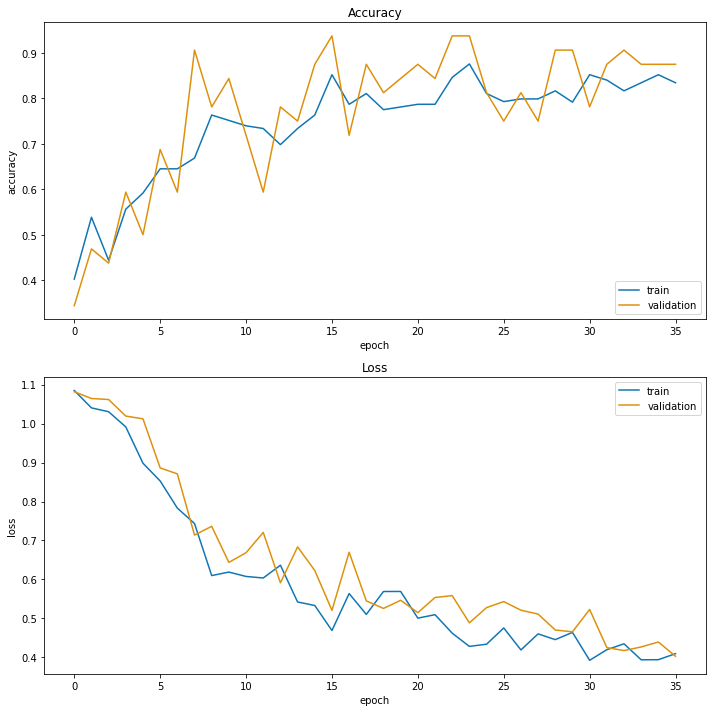

In [39]:
import pandas as pd

FOLDER_PATH = 'drive/My Drive/Deep Learning Projects/Covid-19 and Pneumonia Classification/Trained_Models/' + clf.name

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(hist.history)

# hist_df saved to csv: 
hist_csv_file = FOLDER_PATH + '/history.csv'
with open(hist_csv_file, mode = 'w') as f:
    hist_df.to_csv(f)


from matplotlib import pyplot as plt


fig, axes = plt.subplots(2, 1, figsize = (10, 10))

# Plot training & validation accuracy
axes[0].plot(hist.history['accuracy'], color = '#0F76B3', label = 'train')
axes[0].plot(hist.history['val_accuracy'], color = '#DE900A', label = 'validation')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('accuracy')
axes[0].legend(loc = 'lower right')

# Plot training & validation loss function
axes[1].plot(hist.history['loss'], color = '#0F76B3', label = 'train')
axes[1].plot(hist.history['val_loss'], color = '#DE900A', label = 'validation')
axes[1].set_title('Loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('loss')
axes[1].legend(loc = 'upper right')

plt.tight_layout()
plt.show()


fig.savefig(FOLDER_PATH + '/acc_loss_plot.png')

## Save and Load Keras Models

In [33]:
# Saving the trained model
FOLDER_PATH = 'drive/My Drive/Deep Learning Projects/Covid-19 and Pneumonia Classification/Trained_Models/' + clf.name
clf.save(FOLDER_PATH)

INFO:tensorflow:Assets written to: drive/My Drive/Deep Learning Projects/Covid-19 and Pneumonia Classification/Trained_Models/Covid19_and_Pneumonia_Classifier_v1/assets


# Load the model that we trained earlier

In [ ]:
from tensorflow.keras.models import load_model

FOLDER_PATH = 'drive/My Drive/Deep Learning Projects/Covid-19 and Pneumonia Classification/Trained_Models/' + clf.name

clf = load_model(FOLDER_PATH)

## Predict the Output

In [24]:
test_iterator.reset()
y_pred = clf.predict(test_iterator, steps = len(test_iterator), verbose = 1)

# Get y_test from test_iterator
y_test = test_iterator.labels
y_pred = np.argmax(y_pred, axis = 1)
print(y_test)
print(y_pred)


3/3 [==============================] - 0s 65ms/step


## Confusion matrix visualisation

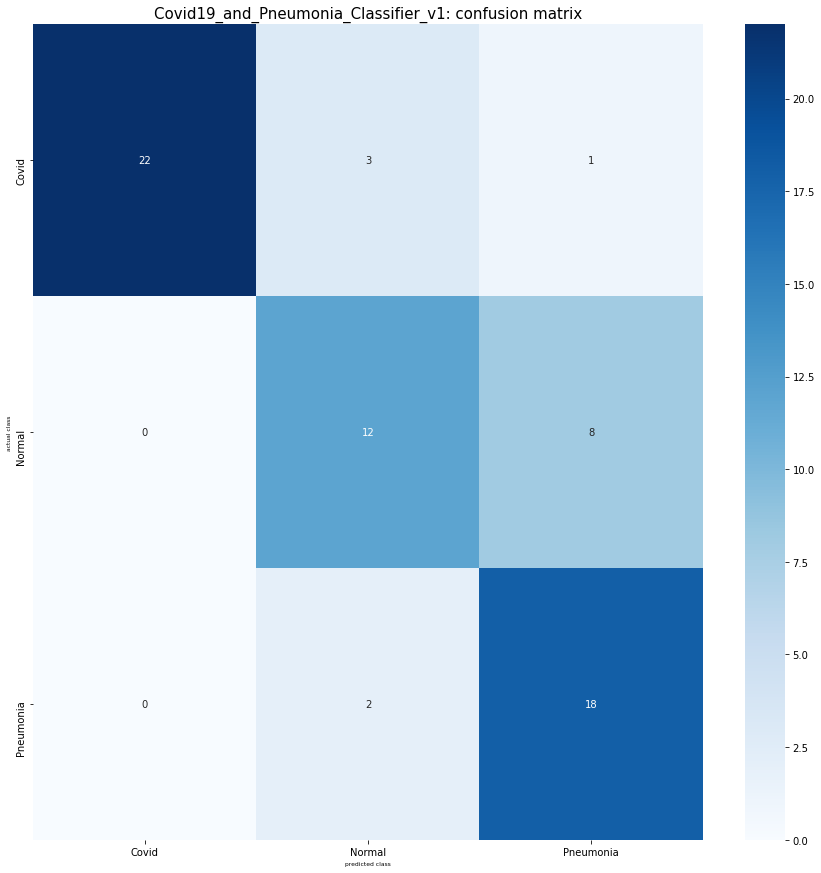

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn

classifier_name = clf.name

# Compute a confusion matrix and plot a heatmap based on that matrix
cm = confusion_matrix(y_test, y_pred)
class_names =  ['Covid', 'Normal', 'Pneumonia']

fig, ax = plt.subplots(figsize = (15, 15))

heatmap = seaborn.heatmap(cm, fmt = 'g', cmap = 'Blues', annot = True, ax = ax)
ax.set_xlabel('predicted class', fontsize = 6)
ax.set_ylabel('actual class', fontsize = 6)
ax.set_title(classifier_name + ': confusion matrix', fontsize = 15)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

heatmap_fig = heatmap.get_figure()
heatmap_fig.savefig(FOLDER_PATH + '/confusion_matrix.png')

## Classification Report

In [35]:
print(classification_report(y_test, y_pred, target_names = class_names))

              precision    recall  f1-score   support

       Covid       1.00      0.85      0.92        26
      Normal       0.71      0.60      0.65        20
   Pneumonia       0.67      0.90      0.77        20

    accuracy                           0.79        66
   macro avg       0.79      0.78      0.78        66
weighted avg       0.81      0.79      0.79        66



## Predict of an Unseen Image

['drive/My Drive/Deep Learning Projects/Covid-19 and Pneumonia Classification/Covid19-dataset/test/Covid/15.png', 'drive/My Drive/Deep Learning Projects/Covid-19 and Pneumonia Classification/Covid19-dataset/test/Covid/16.png', 'drive/My Drive/Deep Learning Projects/Covid-19 and Pneumonia Classification/Covid19-dataset/test/Covid/2.png', 'drive/My Drive/Deep Learning Projects/Covid-19 and Pneumonia Classification/Covid19-dataset/test/Covid/24.png', 'drive/My Drive/Deep Learning Projects/Covid-19 and Pneumonia Classification/Covid19-dataset/test/Covid/25.png', 'drive/My Drive/Deep Learning Projects/Covid-19 and Pneumonia Classification/Covid19-dataset/test/Covid/26.png', 'drive/My Drive/Deep Learning Projects/Covid-19 and Pneumonia Classification/Covid19-dataset/test/Covid/30.png', 'drive/My Drive/Deep Learning Projects/Covid-19 and Pneumonia Classification/Covid19-dataset/test/Covid/38.png', 'drive/My Drive/Deep Learning Projects/Covid-19 and Pneumonia Classification/Covid19-dataset/tes

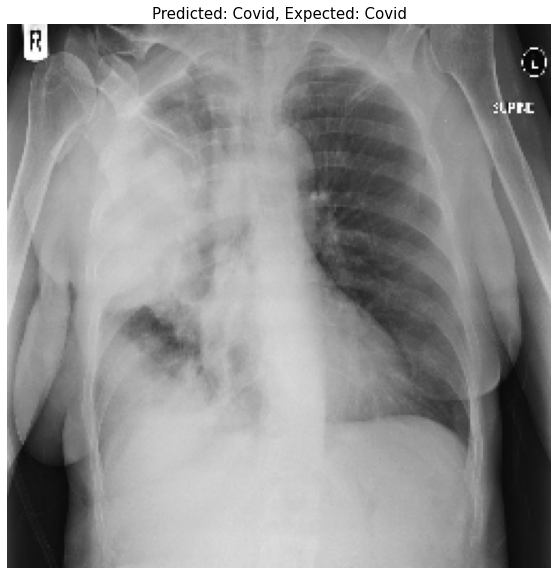

In [80]:
from random import choice
from keras.preprocessing import image

x_test_paths = test_iterator.filepaths
n_test = len(x_test_paths)
print(x_test_paths)

rand_idx = choice([i for i in range(n_test)])
print(rand_idx)
random_img_path = x_test_paths[rand_idx]

print('random_img_path:', random_img_path)

# True label
rand_y_true = y_test[rand_idx]
true_label = class_names[rand_y_true]


# Predicted label
rand_y_pred = y_pred[rand_idx]

print('rand_y_pred:', rand_y_pred)

pred_label = class_names[rand_y_pred]
print(pred_label)

fig, ax = plt.subplots(figsize = (10, 10))

img = image.load_img(random_img_path, target_size = (256, 256))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255

ax.imshow(img_tensor[0])
ax.axis('off')
ax.set_title('Predicted: ' + pred_label + ', Expected: ' + true_label, fontsize = 15)
plt.show()


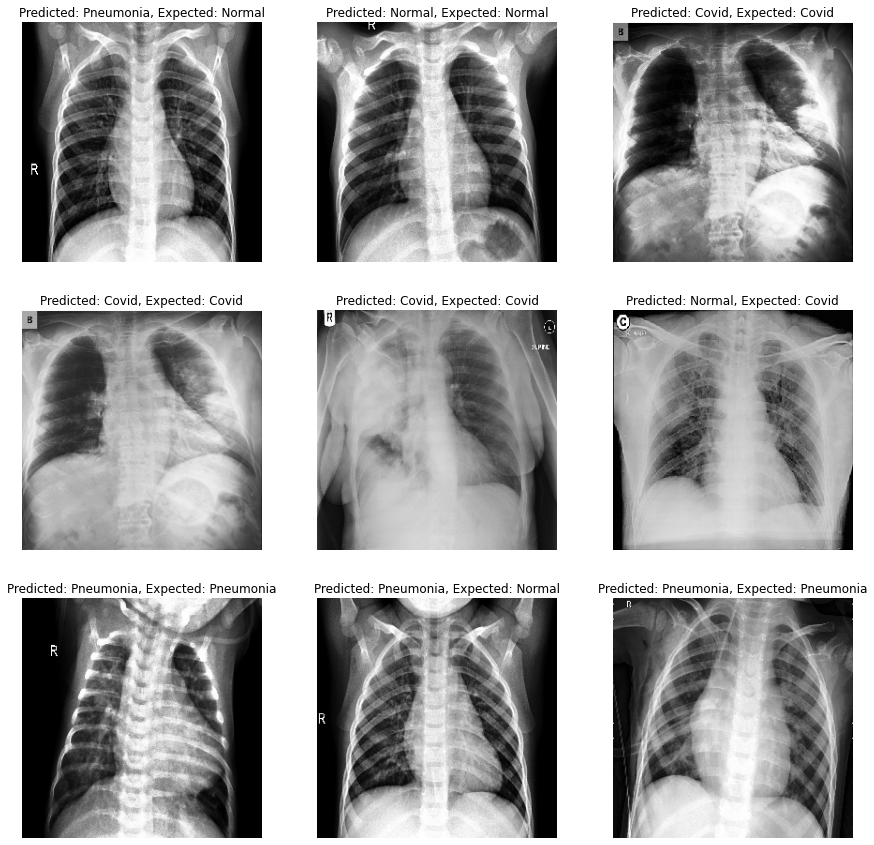

In [97]:
from random import choice
from keras.preprocessing import image

x_test_paths = test_iterator.filepaths
n_test = len(x_test_paths)

fig, ax = plt.subplots(3, 3, figsize = (15, 15))

i = 0
j = 0

while ( (i * 3 + j)  < 9):


  # print('(i, j ) = (%d, %d)' %(i, j))
  rand_idx = choice([i for i in range(n_test)])
  random_img_path = x_test_paths[rand_idx]

  # True label
  rand_y_true = y_test[rand_idx]
  true_label = class_names[rand_y_true]

  # Predicted label
  rand_y_pred = y_pred[rand_idx]
  pred_label = class_names[rand_y_pred]

  # Prepare image
  img = image.load_img(random_img_path, target_size = (256, 256))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis = 0)
  img_tensor /= 255

  
  ax[i, j].imshow(img_tensor[0])
  ax[i, j].axis('off')
  ax[i, j].set_title('Predicted: ' + pred_label + ', Expected: ' + true_label)

  # Update i, j
  if j < 2:
    j += 1
  elif i == 2 & j ==2:
    break;
  else:
    j = 0
    i += 1

plt.show()

TARGET_DIR = 'drive/My Drive/Deep Learning Projects/Covid-19 and Pneumonia Classification/Outputs/'
fig.savefig(TARGET_DIR + clf.name + '_Predictions.png')